# Investigating site variablity in embeddings extracted from different models using t-SNE visualizations.

In [60]:
# Load Dependencies

import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import numpy as np
from omegaconf import OmegaConf, DictConfig
from umap import UMAP


# Custom project imports (update to match your structure)
from data.loaders.abide_loader import get_abide_dataloaders

# ⚙️ Paths and Settings
CHECKPOINT_DIR = "/Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model"
OUTPUT_DIR = "embeddings"
MODEL_NAME = "bnt"  # or "dsam", "bnt", "braingnn"
BATCH_SIZE = 16
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [61]:
# Load Model Checkpoint

def load_model_checkpoint(ckpt_path, cfg, dataloader=None):
    if cfg.models.name == "BrainNetworkTransformer":
        from models.bnt.bnt import BrainNetworkTransformer
        model = BrainNetworkTransformer(cfg)
    elif cfg.models.name == "BrainGNN":
        from models.braingnn.braingnn import Network as BrainGNN
        model = BrainGNN(cfg, dataloader)
    elif cfg.models.name == "SpatioTemporalModel":
        from models.dsam.dsam_original import SpatioTemporalModel
        model = SpatioTemporalModel(cfg, dataloader)
    else:
        raise ValueError(f"Unknown model type: {cfg.models.name}")
    
    state_dict = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    return model.to(device)

In [62]:
# Extract Embeddings from a Model

def extract_embeddings(model, dataloader, device, domain_id):
    model.to(device)
    model.eval()

    all_embeddings, all_labels, all_domains = [], [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting Embeddings"):
            batch = batch.to(device)
            node_feature = batch.x.view(batch.num_graphs, 200, -1)
            time_series = batch.time_series

            feats = model.extract_features(time_series, node_feature)

            all_embeddings.append(feats.cpu())
            all_labels.append(batch.y.cpu())
            all_domains.append(torch.full_like(batch.y, fill_value=domain_id))

    return torch.cat(all_embeddings), torch.cat(all_labels), torch.cat(all_domains)

### Plot with t-SNE

In [63]:


def plot_tsne(embeddings, domains, title="t-SNE by Domain"):
    tsne = TSNE(n_components=2, perplexity=30, init="pca", learning_rate="auto")
    reduced = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=domains, palette="tab20", s=60, alpha=0.8)
    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

###  UMAP Plot Function

In [64]:
def plot_umap(embeddings, domains, title="UMAP by Domain"):
    reducer = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='cosine')
    reduced = reducer.fit_transform(embeddings)

    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=domains, palette="tab20", s=60, alpha=0.8)
    plt.title(title)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

###  t-SNE by Diagnosis (ASD vs TD)

In [65]:
def plot_tsne_by_label(embeddings, labels, title="t-SNE by Diagnosis"):
    import numpy as np
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    import seaborn as sns

    embeddings = np.array(embeddings)
    labels = np.array(labels)

    tsne = TSNE(n_components=2, perplexity=30, init="pca", learning_rate="auto")
    reduced = tsne.fit_transform(embeddings)

    # Ensure matching lengths
    if len(reduced) != len(labels):
        min_len = min(len(reduced), len(labels))
        reduced = reduced[:min_len]
        labels = labels[:min_len]

    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x=reduced[:, 0],
        y=reduced[:, 1],
        hue=labels,
        palette="coolwarm",
        s=60,
        alpha=0.8
    )
    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend(title="Label", labels=["TD", "ASD"], bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

### Silhouette Score + Site Entropy

In [66]:
from scipy.stats import entropy
from collections import Counter

def compute_metrics(embeddings, domains):
    silhouette = silhouette_score(embeddings, domains)
    print(f"Silhouette Score (site clustering): {silhouette:.4f}")

    site_counts = Counter(domains)
    p = np.array([site_counts[k] for k in sorted(site_counts)])
    p = p / p.sum()
    ent = entropy(p, base=2)
    print(f"Site Entropy (bits): {ent:.4f}")
    return silhouette, ent

In [67]:
# Load Config and Run End-to-End

from hydra import initialize, compose

# Initialize Hydra config manually (for notebooks)
with initialize(version_base=None, config_path="config"):
    cfg = compose(config_name="config")
    print(OmegaConf.to_yaml(cfg))

os.makedirs(OUTPUT_DIR, exist_ok=True)
site_data, site_names = get_abide_dataloaders(cfg)

all_emb, all_lbl, all_dom = [], [], []

for site in site_names:
    domain_id = site_names.index(site)
    model_name = f"Baseline-{MODEL_NAME}_{site}.pt"
    ckpt_path = os.path.join(CHECKPOINT_DIR, model_name)

    if not os.path.exists(ckpt_path):
        print(f"[SKIP] Missing checkpoint for {site}")
        continue

    print(f"[LOAD] Loading checkpoint for {site} from {ckpt_path}")
    dataloader = DataLoader(site_data[site], batch_size=BATCH_SIZE, shuffle=False)
    model = load_model_checkpoint(ckpt_path, cfg, dataloader)

    emb, lbl, dom = extract_embeddings(model, dataloader, device, domain_id)
    all_emb.append(emb)
    all_lbl.append(lbl)
    all_dom.append(dom)

    torch.save((emb, lbl, dom), os.path.join(OUTPUT_DIR, f"{model_name}_{site}.pt"))

repeat_time: 1
log_path: result
save_learnable_graph: false
local_host: false
wandb_entity: eggroup
project: Domain Adaptation - Tuned
dataset:
  name: abide
  batch_size: 16
  test_batch_size: 16
  val_batch_size: 16
  val_split: 0.1
  root: /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain
    Adaptation/data/abide/ABIDE_pcp/cpac/filt_noglobal
  stratified: true
  drop_last: true
  atlas: CC200
  connectivity: correlation
  use_h5: false
  phenotypic_file: /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain
    Adaptation/data/abide/ABIDE_pcp/Phenotypic_V1_0b_preprocessed1.csv
  edge_threshold: 75
  include_ados: true
  use_1d: true
  dynamic: true
  num_nodes: 200
  time_points: 124
  site: null
models:
  name: BrainNetworkTransformer
  alias: bnt
  sizes:
  - 360
  - 100
  pooling:
  - false
  - true
  pos_encoding: none
  orthogonal: true
  freeze_center: true
  project_assignment: true
  pos_embed_dim: 360
  feature_dim: 800
  patie

/opt/anaconda3/envs/env-01/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/var/folders/0f/kqcd07951gl12v32d1bck03r0000gn/T/ipykernel_15044/4263525844.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `we

[DEBUG] Extracted features shape: torch.Size([16, 800])
[DEBUG] Extracted features shape: torch.Size([16, 800])
[DEBUG] Extracted features shape: torch.Size([5, 800])
[LOAD] Loading checkpoint for CMU from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/Baseline-bnt_CMU.pt
[DEBUG] BNT initialized with forward_dim: 200, num_nodes: 200, dropout: 0.5
[DEBUG] Expected input to fc: 800


Extracting Embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

[DEBUG] Extracted features shape: torch.Size([16, 800])


Extracting Embeddings: 100%|██████████| 2/2 [00:00<00:00, 28.27it/s]


[DEBUG] Extracted features shape: torch.Size([11, 800])
[LOAD] Loading checkpoint for KKI from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/Baseline-bnt_KKI.pt
[DEBUG] BNT initialized with forward_dim: 200, num_nodes: 200, dropout: 0.5
[DEBUG] Expected input to fc: 800


Extracting Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]

[DEBUG] Extracted features shape: torch.Size([16, 800])


Extracting Embeddings: 100%|██████████| 3/3 [00:00<00:00, 16.33it/s]


[DEBUG] Extracted features shape: torch.Size([16, 800])
[DEBUG] Extracted features shape: torch.Size([16, 800])
[LOAD] Loading checkpoint for LEUVEN_1 from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/Baseline-bnt_LEUVEN_1.pt
[DEBUG] BNT initialized with forward_dim: 200, num_nodes: 200, dropout: 0.5
[DEBUG] Expected input to fc: 800


Extracting Embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

[DEBUG] Extracted features shape: torch.Size([16, 800])


Extracting Embeddings: 100%|██████████| 2/2 [00:00<00:00, 21.39it/s]


[DEBUG] Extracted features shape: torch.Size([13, 800])
[LOAD] Loading checkpoint for LEUVEN_2 from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/Baseline-bnt_LEUVEN_2.pt
[DEBUG] BNT initialized with forward_dim: 200, num_nodes: 200, dropout: 0.5
[DEBUG] Expected input to fc: 800


Extracting Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]

[DEBUG] Extracted features shape: torch.Size([16, 800])
[DEBUG] Extracted features shape: torch.Size([16, 800])


Extracting Embeddings: 100%|██████████| 3/3 [00:00<00:00, 36.63it/s]

[DEBUG] Extracted features shape: torch.Size([2, 800])
[LOAD] Loading checkpoint for MAX_MUN from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/Baseline-bnt_MAX_MUN.pt
[DEBUG] BNT initialized with forward_dim: 200, num_nodes: 200, dropout: 0.5
[DEBUG] Expected input to fc: 800



Extracting Embeddings: 100%|██████████| 1/1 [00:00<00:00, 40.21it/s]


[DEBUG] Extracted features shape: torch.Size([16, 800])
[LOAD] Loading checkpoint for NYU from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/Baseline-bnt_NYU.pt
[DEBUG] BNT initialized with forward_dim: 200, num_nodes: 200, dropout: 0.5
[DEBUG] Expected input to fc: 800


Extracting Embeddings:  18%|█▊        | 2/11 [00:00<00:00, 17.97it/s]

[DEBUG] Extracted features shape: torch.Size([16, 800])
[DEBUG] Extracted features shape: torch.Size([16, 800])
[DEBUG] Extracted features shape: torch.Size([16, 800])


Extracting Embeddings:  45%|████▌     | 5/11 [00:00<00:00, 21.35it/s]

[DEBUG] Extracted features shape: torch.Size([16, 800])
[DEBUG] Extracted features shape: torch.Size([16, 800])
[DEBUG] Extracted features shape: torch.Size([16, 800])
[DEBUG] Extracted features shape: torch.Size([16, 800])


Extracting Embeddings:  73%|███████▎  | 8/11 [00:00<00:00, 23.05it/s]

[DEBUG] Extracted features shape: torch.Size([16, 800])
[DEBUG] Extracted features shape: torch.Size([16, 800])
[DEBUG] Extracted features shape: torch.Size([16, 800])


Extracting Embeddings: 100%|██████████| 11/11 [00:00<00:00, 20.32it/s]

[DEBUG] Extracted features shape: torch.Size([15, 800])
[LOAD] Loading checkpoint for OLIN from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/Baseline-bnt_OLIN.pt
[DEBUG] BNT initialized with forward_dim: 200, num_nodes: 200, dropout: 0.5


[DEBUG] Expected input to fc: 800


Extracting Embeddings: 100%|██████████| 3/3 [00:00<00:00, 27.07it/s]

[DEBUG] Extracted features shape: torch.Size([16, 800])
[DEBUG] Extracted features shape: torch.Size([16, 800])
[DEBUG] Extracted features shape: torch.Size([2, 800])


[LOAD] Loading checkpoint for PITT from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/Baseline-bnt_PITT.pt
[DEBUG] BNT initialized with forward_dim: 200, num_nodes: 200, dropout: 0.5
[DEBUG] Expected input to fc: 800


Extracting Embeddings:   0%|          | 0/4 [00:00<?, ?it/s]

[DEBUG] Extracted features shape: torch.Size([16, 800])


Extracting Embeddings:  75%|███████▌  | 3/4 [00:00<00:00, 23.88it/s]

[DEBUG] Extracted features shape: torch.Size([16, 800])
[DEBUG] Extracted features shape: torch.Size([16, 800])


Extracting Embeddings: 100%|██████████| 4/4 [00:00<00:00, 24.84it/s]


[DEBUG] Extracted features shape: torch.Size([8, 800])
[LOAD] Loading checkpoint for SBL from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/Baseline-bnt_SBL.pt
[DEBUG] BNT initialized with forward_dim: 200, num_nodes: 200, dropout: 0.5
[DEBUG] Expected input to fc: 800


Extracting Embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

[DEBUG] Extracted features shape: torch.Size([16, 800])


Extracting Embeddings: 100%|██████████| 2/2 [00:00<00:00, 20.05it/s]

[DEBUG] Extracted features shape: torch.Size([14, 800])
[LOAD] Loading checkpoint for SDSU from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/Baseline-bnt_SDSU.pt
[DEBUG] BNT initialized with forward_dim: 200, num_nodes: 200, dropout: 0.5


[DEBUG] Expected input to fc: 800


Extracting Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]

[DEBUG] Extracted features shape: torch.Size([16, 800])


Extracting Embeddings:  67%|██████▋   | 2/3 [00:00<00:00, 18.77it/s]

[DEBUG] Extracted features shape: torch.Size([16, 800])


Extracting Embeddings: 100%|██████████| 3/3 [00:00<00:00, 18.11it/s]


[DEBUG] Extracted features shape: torch.Size([4, 800])
[LOAD] Loading checkpoint for STANFORD from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/Baseline-bnt_STANFORD.pt
[DEBUG] BNT initialized with forward_dim: 200, num_nodes: 200, dropout: 0.5
[DEBUG] Expected input to fc: 800


Extracting Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]

[DEBUG] Extracted features shape: torch.Size([16, 800])
[DEBUG] Extracted features shape: torch.Size([16, 800])


Extracting Embeddings: 100%|██████████| 3/3 [00:00<00:00, 23.65it/s]


[DEBUG] Extracted features shape: torch.Size([7, 800])
[LOAD] Loading checkpoint for TRINITY from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/Baseline-bnt_TRINITY.pt
[DEBUG] BNT initialized with forward_dim: 200, num_nodes: 200, dropout: 0.5
[DEBUG] Expected input to fc: 800


Extracting Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]

[DEBUG] Extracted features shape: torch.Size([16, 800])
[DEBUG] Extracted features shape: torch.Size([16, 800])


Extracting Embeddings: 100%|██████████| 3/3 [00:00<00:00, 21.41it/s]


[DEBUG] Extracted features shape: torch.Size([15, 800])
[LOAD] Loading checkpoint for UM_1 from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/Baseline-bnt_UM_1.pt
[DEBUG] BNT initialized with forward_dim: 200, num_nodes: 200, dropout: 0.5
[DEBUG] Expected input to fc: 800


Extracting Embeddings:   0%|          | 0/7 [00:00<?, ?it/s]

[DEBUG] Extracted features shape: torch.Size([16, 800])
[DEBUG] Extracted features shape: torch.Size([16, 800])
[DEBUG] Extracted features shape: torch.Size([16, 800])


Extracting Embeddings:  43%|████▎     | 3/7 [00:00<00:00, 24.20it/s]

[DEBUG] Extracted features shape: torch.Size([16, 800])
[DEBUG] Extracted features shape: torch.Size([16, 800])
[DEBUG] Extracted features shape: torch.Size([16, 800])


Extracting Embeddings: 100%|██████████| 7/7 [00:00<00:00, 21.25it/s]

[DEBUG] Extracted features shape: torch.Size([10, 800])
[LOAD] Loading checkpoint for UM_2 from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/Baseline-bnt_UM_2.pt
[DEBUG] BNT initialized with forward_dim: 200, num_nodes: 200, dropout: 0.5


[DEBUG] Expected input to fc: 800


Extracting Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]

[DEBUG] Extracted features shape: torch.Size([16, 800])
[DEBUG] Extracted features shape: torch.Size([16, 800])


Extracting Embeddings: 100%|██████████| 3/3 [00:00<00:00, 26.09it/s]

[DEBUG] Extracted features shape: torch.Size([2, 800])
[LOAD] Loading checkpoint for USM from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/Baseline-bnt_USM.pt
[DEBUG] BNT initialized with forward_dim: 200, num_nodes: 200, dropout: 0.5


[DEBUG] Expected input to fc: 800


Extracting Embeddings:   0%|          | 0/5 [00:00<?, ?it/s]

[DEBUG] Extracted features shape: torch.Size([16, 800])
[DEBUG] Extracted features shape: torch.Size([16, 800])


Extracting Embeddings:  60%|██████    | 3/5 [00:00<00:00, 23.03it/s]

[DEBUG] Extracted features shape: torch.Size([16, 800])


Extracting Embeddings: 100%|██████████| 5/5 [00:00<00:00, 23.89it/s]

[DEBUG] Extracted features shape: torch.Size([16, 800])
[DEBUG] Extracted features shape: torch.Size([7, 800])
[LOAD] Loading checkpoint for YALE from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/Baseline-bnt_YALE.pt
[DEBUG] BNT initialized with forward_dim: 200, num_nodes: 200, dropout: 0.5
[DEBUG] Expected input to fc: 800



Extracting Embeddings:   0%|          | 0/4 [00:00<?, ?it/s]

[DEBUG] Extracted features shape: torch.Size([16, 800])
[DEBUG] Extracted features shape: torch.Size([16, 800])


Extracting Embeddings: 100%|██████████| 4/4 [00:00<00:00, 22.44it/s]

[DEBUG] Extracted features shape: torch.Size([16, 800])
[DEBUG] Extracted features shape: torch.Size([8, 800])


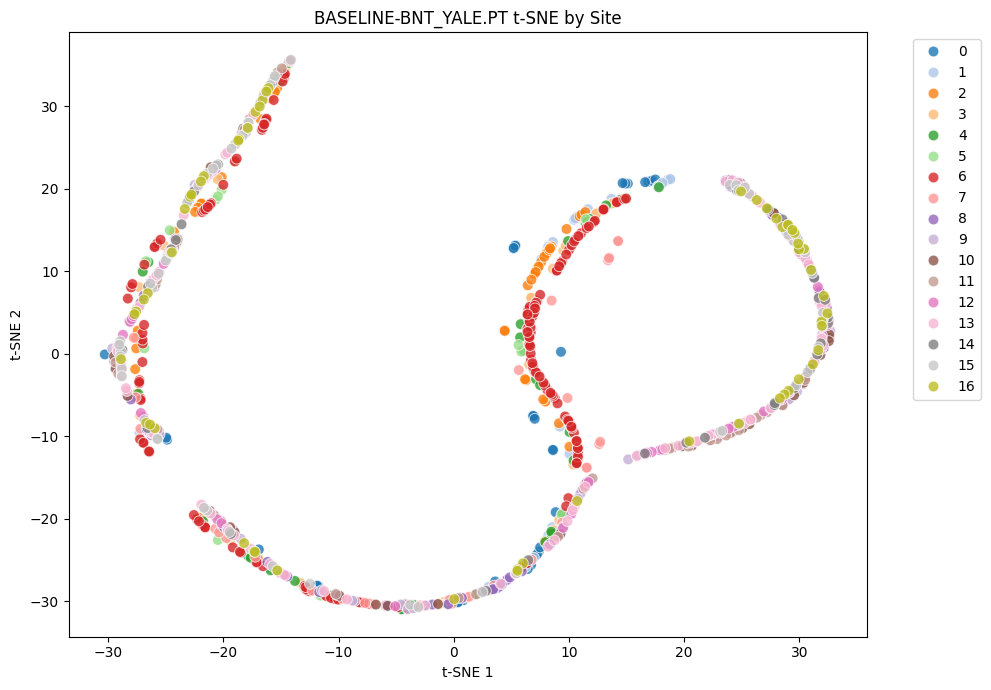

In [68]:
# Run t-SNE on All Extracted Embeddings

if len(all_emb) == 0:
    print("[ERROR] No embeddings found.")
else:
    all_emb = torch.cat(all_emb).cpu().numpy()
    all_dom = torch.cat(all_dom).cpu().numpy()
    # all_lbl = torch.cat(all_lbl).cpu().numpy()
    plot_tsne(all_emb, all_dom, title=f"{model_name.upper()} t-SNE by Site")

In [69]:
# os.environ["NUMBA_THREADING_LAYER"] = "workqueue"
# plot_umap(all_emb, all_dom, title="UMAP by Site")

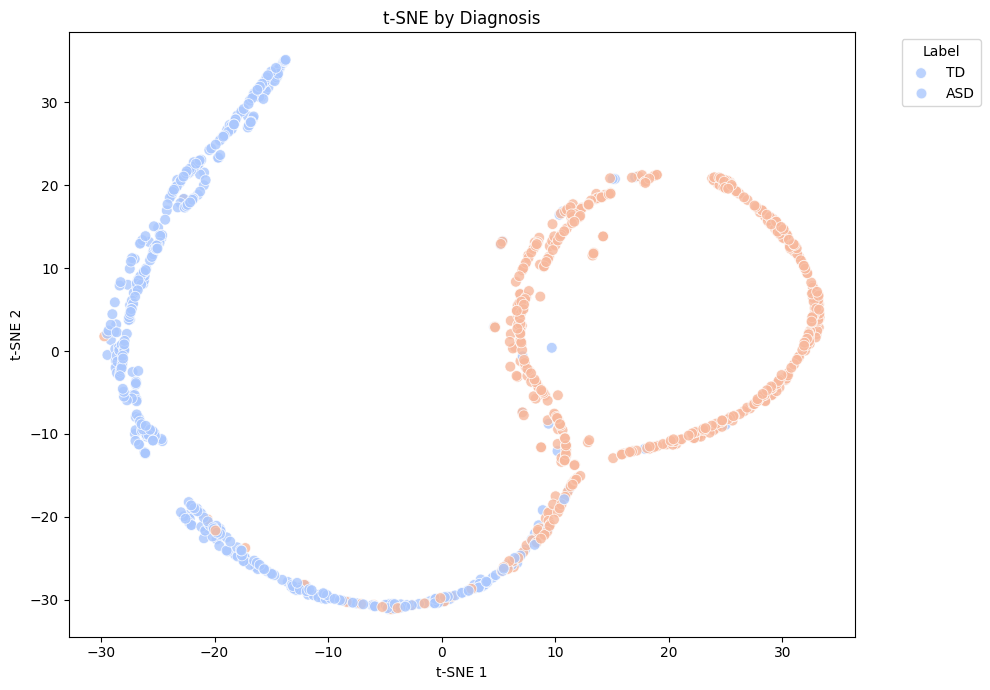

In [70]:
all_lbl = torch.cat(all_lbl).cpu().numpy()
plot_tsne_by_label(all_emb, all_lbl, title="t-SNE by Diagnosis")

In [71]:
compute_metrics(all_emb, all_dom)

Silhouette Score (site clustering): -0.1913
Site Entropy (bits): 3.8100


(-0.19128012657165527, np.float64(3.8100417372547413))